# F21DL - ML Portfolio Coursework 
### MIT Places Dataset for identifying places using computer vision
#### Rucha Tare
#### Maxime Mavel
#### Daniel Eneh
#### Aurélien Lohmann


## Step 1 - Data Sourcing: 
We chose MIT places mini dataset from below 4 datasets 

1. Bird species classification - BIRDS 400 - SPECIES IMAGE CLASSIFICATION | Kaggle (Links to an external site.)
     
     Source: Kaggle

     Data Description: Data helps to predict bird species with help of images and attributes tagged to images. Data has species of 400 birds and number of images for each species. It also has attributes like height, weight of the image used, name of the bird and class of the bird species. The data is already divided into test and train folders. It has 400 instances

2. Australian Sign Language: UCI Machine Learning Repository: Australian Sign Language signs Data Set (Links to an external site.)

   Source: UCL Machine Learning Repository

   Data description: Data has x,y,z coordinate measurements of a Nintendo Glove that helps to predict that Australian Sign Language. The data has 15 attributes related to positions of the co-ordinate and images with 6650 instances

3. Movie Genre prediction from its posters: Movie Genre from its Poster | Kaggle (Links to an external site.)
 Source - Kaggle

 Description of the data: This dataset has images of the movie posters and movie attributes like IMDB ID, IMDB link, Genre, Ranking. It has 998 instances.

Pros: 
1. Has combination of images and attributes 
2. Since we have a lot of movie posters on internet, we can tweak data sets to add more instances if needed or manipulate the data
3. We can test the model on newer poster every time so that it actually predicts accurate results as compared to above bird or sign languages.
Attributes have link, text,number, floats to play around with


4. MIT places Mini dataset: We later found this MIT places mini dataset which is a great places dataset originally created by MIT AI researchers. It has 100,000 images labelled. We have taken subset of it not all the dataset hence it is called mini MIT places 
http://dl.caffe.berkeleyvision.org/mit_mini_places/

Source : Google

Pros of this dataset :

1. More number of instances

2. Credible datasets by MIT researchers

3. More number of features will help us learn and explore more

4. Versatile dataset that can be played around with many applications and things are it identifying places and scenes 

Cons with First three datasets:

1. Creating new data will be troublesome as we don't have images and attributes.

2. Australian sign language attributes are just coordinates so it is not much to play around with, similar to the bird dataset that mostly has numbers and two text columns

3. Movie was a great dataset but number of instances were 998 only. 

Conclusion: Due to above cons we decided to choose the MIT places dataset

GITLAB Repo link :  https://gitlab-student.macs.hw.ac.uk/rt2026/ml-portoflio-mit-places
Github Repo link : https://github.com/RuchaTare/ML-portfolio

### 1.1 - Importing Relevant Libraries and data options

In [118]:
# ignore warnings
import warnings

# importing needed libraries to python
import pandas as pd
import os
import re
import numpy as np

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from collections import Counter

# import openCV
import cv2

# sklearn imports
from sklearn import preprocessing
from sklearn.model_selection import (train_test_split, cross_val_score, 
                                     cross_val_predict, cross_validate, 
                                     RandomizedSearchCV)

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.linear_model import SGDClassifier, LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import (accuracy_score, f1_score, 
                             recall_score, precision_score, 
                             confusion_matrix, mean_squared_error)

# keras imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')


### Configurations

In [2]:
category_dir = 'labels/'
image_dir = 'images'

In [3]:
categories_txt = 'categories.txt'
train_txt= 'train.txt'
val_txt= 'val.txt'
path_train= category_dir + train_txt
path_val = category_dir + val_txt 

## Step 2 - Data Loading and Data preprocessing

Data Description: 
 categories.txt - 0-99 categories

 train.txt - training dataset to categorise images

 training data images- 100,000 Images for all the 0-99 categories
 
 
 

### Creating Category Dataset

In [4]:
categories_file = open(f'{category_dir}{categories_txt}', 'r') 
category_records = categories_file.readlines()
categories_file.close()

We are creating a dictionary for category that will have category id and category record so that we can later verify the category name with the id. Since few categories also have sub categories in them e.g /i/ice_skating_rink/outdoor 56 we are replacing "/" to "-". So that we get the prediction as ice_skating_rink - outdoor

In [5]:
categories_dataset = {}
for category_record in category_records:
    category_name, category_id = category_record.split(" ")
    category_name = category_name[3:].replace('/','-')
    
    categories_dataset[int(category_id)] = category_name

### Image Preprocessing

In [6]:
# verifying the image path
print(f'{image_dir}/train/a/abbey/00000001.jpg')

images/train/a/abbey/00000001.jpg


In [7]:
# reading a test image for two reasons: 1. Checking the image 2. Using the image to take 80% of its dimensions to scale 
test_image = cv2.imread(f'{image_dir}/train/a/abbey/00000001.jpg', cv2.IMREAD_COLOR)

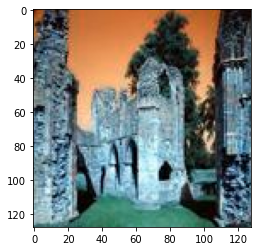

In [8]:
# verifying the image plot for test image
plt.imshow(test_image)
plt.show()

In [9]:
# getting the 25% size for image for further preprocessing
SCALE_PERCENT = 25
WIDTH = int(test_image.shape[1] * SCALE_PERCENT / 100)
HEIGHT = int(test_image.shape[0] * SCALE_PERCENT / 100)
DIM = (WIDTH, HEIGHT)

# printing the scaled size of the test image. We will use these dimensions in the below function while scaling train and val images
print("Scaled image size should be: ", DIM)

Scaled image size should be:  (32, 32)


In [10]:
def image_resize(image):
    """ Function to define resizing images. This will be called from image_preprocess
    Args: 
        image: image
    returns:
        image_rs: image resized 
    """
    image_rs = cv2.resize(image, DIM, interpolation=cv2.INTER_AREA)

    return image_rs        

In [21]:
def image_to_array(images):
    """ Defining function to convert images to array
    Args:
        images: list of images
    returns:
        images_arr_rs: array of reshaped images
    """
    # Data Normalization
    images = np.array(images)
    images = images.astype('float32') 
    # Normalization
    images = images/255.0
    images_arr_rs = images.reshape((len(images), -1))

    return images

In [12]:
def preprocess_image(image_dir, category_path):
    """ Defining a function to read, resize images and categories
    Args:
        image_dir: image_dir to read images from
        category_path: category path to read categories
    """
    images = []
    image_paths = []
    categories = []
    file = open(category_path, 'r') 
    label_records = file.readlines()
    file.close()

    for record in label_records:
        # split each line on label file using spaces into image path and category id
        image_path, category = record.split(" ")  

        # load images and resize
        image_w = cv2.imread(f'{image_dir}/{image_path}', cv2.IMREAD_COLOR)
        image_bw = cv2.cvtColor(image_w, cv2.COLOR_BGR2GRAY)
        image_bw = image_resize(image_bw)
        
        # load filenames as a list
        image_paths.append(f'{image_dir}/{image_path}')

        # adding image and category to the list
        images.append(image_bw)
        categories.append(int(category))
        
    return images, categories, image_paths

abbey


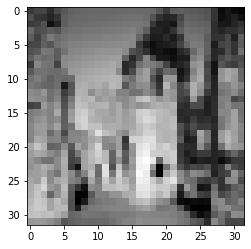

In [13]:
# getting train dataset by calling preprocess and plotting a train image and verifying its category
images_train, category_train, image_paths_train = preprocess_image(image_dir, path_train)
print(categories_dataset[category_train[0]])
plt.imshow(images_train[0], cmap='gray')
plt.show()

palace


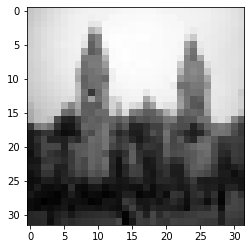

In [14]:
# getting validation dataset by calling preprocess and plotting a val image and verifying its category
images_val, category_val, image_paths_val = preprocess_image(image_dir, path_val)
print(categories_dataset[category_val[0]])
plt.imshow(images_val[0], cmap='gray')
plt.show()

In [15]:
# calling images to array and getting X train, Y train, X val , Y val
X = image_to_array(images_train)
y = pd.DataFrame(category_train, columns=['category'])
X_val = image_to_array(images_val)
y_val = pd.DataFrame(category_val, columns=['category'])

In [16]:
X_train, X_train_inventory, y_train, y_train_inventory = train_test_split(X, y, test_size=0.70, random_state=42, stratify=y)

In [17]:
X_val, X_val_inventory, y_val, y_val_inventory = train_test_split(X_val, y_val, test_size=0.60, random_state=42, stratify=y_val)

In [18]:
print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)

X_train Shape:  (30000, 1024)
y_train Shape:  (30000, 1)
X_val Shape:  (4000, 1024)
y_val Shape:  (4000, 1)


---

### Getting the datasets for Neural Networks training

abbey


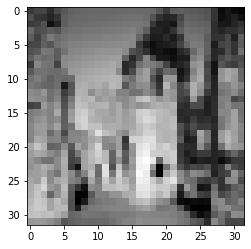

In [19]:
# getting train dataset by calling preprocess and plotting a train image and verifying its category for Neural Networks
# change the image size in the above cell to increase the size
images_train_NN, category_train_NN, image_paths_train_NN = preprocess_image(image_dir, path_train)
print(categories_dataset[category_train_NN[0]])
plt.imshow(images_train_NN[0], cmap='gray')
plt.show()

palace


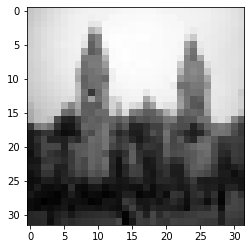

In [20]:
images_val_NN, category_val_NN, image_paths_val_NN = preprocess_image(image_dir, path_val)
print(categories_dataset[category_val_NN[0]])
plt.imshow(images_val_NN[0], cmap='gray')
plt.show()

In [22]:
# calling images to array and getting X train, Y train, X val , Y val
X_nn = image_to_array(images_train_NN)
y_nn = pd.DataFrame(category_train_NN, columns=['category'])

In [23]:
X_test_nn = image_to_array(images_val_NN)
y_test_nn = pd.DataFrame(category_val_NN, columns=['category'])

In [24]:
X_train_nn, X_val_nn, y_train_nn, y_val_nn = train_test_split(X_nn, y_nn, test_size=0.10, random_state=42, stratify=y_nn)

In [25]:
print("X_train Shape: ", X_train_nn.shape)
print("y_train Shape: ", y_train_nn.shape)
print("X_val Shape: ", X_test_nn.shape)
print("y_val Shape: ", y_test_nn.shape)

X_train Shape:  (90000, 32, 32)
y_train Shape:  (90000, 1)
X_val Shape:  (10000, 32, 32)
y_val Shape:  (10000, 1)


---

# Model Monitoring Helper Functions

In [26]:
def get_cross_validation(model, X, y, scoring, cv=10):
    """ Function to get the cross validation for model
    Args:
        model:
        X_train:
        y_train:
        cv:
    """
    cross_validation_results = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    
    return cross_validation_results

In [27]:
# graph representation
def plot_histogram(x, bins=10, title="Histogram"):
    """ Provides graph to display cluster and its counts
    """
    plt.hist(x, bins=bins)
    plt.title(title)
    return plt.show

    
def plot_cv_results(cv_results, param_x, param_hue, metric='mean_test_score'):
    """ Plotting the graph for two parameters from Random Search CV
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_hue = 'param_' + param_hue
    
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_hue, data=cv_results, ci=99, n_boot=64, ax=ax)
    
    ax.set_title("CV Random Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_hue)
    
    return fig


In [28]:
def get_model_report(y_true, y_pred):
    """ Provides a model performance report 
    """
    model_accuracy = accuracy_score(y_true, y_pred)
    model_f1_score = f1_score(y_true, y_pred, average='weighted')
    model_precision = precision_score(y_true, y_pred, average='weighted')
    model_recall = recall_score(y_true, y_pred, average='weighted')
    
    print(f"Model Accuracy: {round(model_accuracy, 3)}")
    print(f"Model F1 Score: {round(model_f1_score, 3)}")
    print(f"Model Precision: {round(model_precision, 3)}")
    print(f"Model Recall: {round(model_recall, 3)}")
    
    return model_accuracy

In [29]:
models_summary = pd.DataFrame(columns = ['Model Name', 
                                         'Train Accuracy', 
                                         'Test Accuracy',
                                        ])
def add_to_model_summary(models_summary, model_name, train_acc, test_acc):
    """ Adding model performance summary to compare models
    """
    models_summary = models_summary.append({'Model Name': model_name, 
                           'Train Accuracy': train_acc, 
                           'Test Accuracy': test_acc}, ignore_index=True)
    return models_summary


## Modelling

### 1. Classification 

In [30]:
sgd_clf = SGDClassifier(max_iter=10, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(max_iter=10, random_state=42)

In [31]:
get_cross_validation(sgd_clf, X_train, y_train, scoring="accuracy", cv=5)

array([0.02083333, 0.024     , 0.019     , 0.01933333, 0.024     ])

In [32]:
y_pred_train_sgd_clf = sgd_clf.predict(X_train)
y_pred_test_sgd_clf = sgd_clf.predict(X_val)

In [33]:
model_sgd_train_accuracy = get_model_report(y_train, y_pred_train_sgd_clf)
model_sgd_test_accuracy = get_model_report(y_val, y_pred_test_sgd_clf)
models_summary = add_to_model_summary(models_summary, 'SGD Classifier', model_sgd_train_accuracy, model_sgd_test_accuracy)

Model Accuracy: 0.066
Model F1 Score: 0.053
Model Precision: 0.223
Model Recall: 0.066
Model Accuracy: 0.02
Model F1 Score: 0.009
Model Precision: 0.018
Model Recall: 0.02


### Conclusion : 
Classification gives best Model Accuracy: 6.6% in train and very low of 2 % in validation. We expect this to be better in later stage as it is image dataset



### 2. Multinomial NB

In [34]:
model_MNB = MultinomialNB()
model_MNB.fit(X_train, y_train)

MultinomialNB()

In [35]:
model_MNB.predict(X_val)

array([94, 46,  2, ..., 36, 98, 56])

In [36]:
cross_val_score(model_MNB, X_train, y_train, cv=3, scoring="accuracy") 

array([0.0309, 0.0317, 0.0316])

In [37]:
y_pred_MNB = cross_val_predict(model_MNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_MNB)

array([[ 0,  0,  0, ...,  6,  7,  0],
       [ 1,  0,  1, ...,  2,  2,  0],
       [ 0,  0,  0, ...,  3,  2,  1],
       ...,
       [ 0,  0,  0, ...,  7, 10,  1],
       [ 1,  0,  0, ...,  7,  7,  0],
       [ 0,  1,  1, ...,  4,  3,  0]])

In [38]:
y_pred_train_model_MNB = model_MNB.predict(X_train)
y_pred_test_model_MNB = model_MNB.predict(X_val)

In [39]:
model_MNB_train_accuracy = get_model_report(y_train, y_pred_train_model_MNB)
model_MNB_test_accuracy = get_model_report(y_val, y_pred_test_model_MNB)
models_summary = add_to_model_summary(models_summary, 'Multinomial NB', model_MNB_train_accuracy, model_MNB_test_accuracy)

Model Accuracy: 0.038
Model F1 Score: 0.024
Model Precision: 0.037
Model Recall: 0.038
Model Accuracy: 0.035
Model F1 Score: 0.02
Model Precision: 0.025
Model Recall: 0.035


Conclusion : Multinomial NB gives train accuracy as 3.8 %

### Gaussian NB

In [40]:
model_GNB = GaussianNB()
model_GNB.fit(X_train, y_train)

GaussianNB()

In [41]:
cross_val_score(model_GNB, X_train, y_train, cv=3, scoring="accuracy")

array([0.0443, 0.0429, 0.0424])

In [42]:
y_pred_GNB = cross_val_predict(model_GNB, X_val, y_val, cv=3)
confusion_matrix(y_val, y_pred_GNB)

array([[0, 0, 0, ..., 5, 4, 0],
       [0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 3, 1, 0],
       ...,
       [0, 0, 0, ..., 9, 4, 0],
       [0, 0, 0, ..., 5, 5, 0],
       [1, 0, 0, ..., 3, 3, 0]])

In [43]:
y_pred_train_model_GNB = model_GNB.predict(X_train)
y_pred_test_model_GNB = model_GNB.predict(X_val)

In [44]:
model_GNB_train_accuracy = get_model_report(y_train, y_pred_train_model_GNB)
model_GNB_test_accuracy = get_model_report(y_val, y_pred_test_model_GNB)
models_summary = add_to_model_summary(models_summary, 'Gaussian NB', model_GNB_train_accuracy, model_GNB_test_accuracy)

Model Accuracy: 0.051
Model F1 Score: 0.031
Model Precision: 0.061
Model Recall: 0.051
Model Accuracy: 0.044
Model F1 Score: 0.023
Model Precision: 0.024
Model Recall: 0.044


Conclusion : Gaussian NB gives us train accuracy as 5.1 % and validation accuracy as 4.4%

### Complement NB

In [45]:
model_CNB = ComplementNB()
model_CNB.fit(X_train, y_train)

ComplementNB()

In [46]:
cross_val_score(model_CNB, X_train, y_train, cv=3, scoring="accuracy")

array([0.0238, 0.021 , 0.0244])

In [47]:
y_pred_train_model_CNB = model_CNB.predict(X_train)
y_pred_test_model_CNB = model_CNB.predict(X_val)

In [48]:
model_CNB_train_accuracy = get_model_report(y_train, y_pred_train_model_CNB)
model_CNB_test_accuracy = get_model_report(y_val, y_pred_test_model_CNB)
models_summary = add_to_model_summary(models_summary, 'Complement NB', model_CNB_train_accuracy, model_CNB_test_accuracy)

Model Accuracy: 0.027
Model F1 Score: 0.009
Model Precision: 0.053
Model Recall: 0.027
Model Accuracy: 0.026
Model F1 Score: 0.009
Model Precision: 0.021
Model Recall: 0.026


Conclusion : Complement NB gives us train accuracy as 2.7 % and validation accuracy as 2.6%
            From all the NB models Gaussian gives a better result in train and validation combined

## Clustering

In [49]:
total_clusters = len(np.unique(y_train))

In [50]:
def get_reference_labels(cluster_labels, y, total_clusters):
    """
    """
    # Initializing
    refer_labels = {}
    
    # loop through each label of cluster
    for i in range(total_clusters):
        index = np.where(cluster_labels == i, 1, 0)
        num = np.bincount(y[[index == 1]]).argmax()
        refer_labels[i] = num
    
    return refer_labels

### Gaussian Mixture

In [ ]:
# Initialize the Gaussian Mixture model
model_GM = GaussianMixture(n_components=10, random_state=42)

# Fitting the model to training set
model_GM.fit(X_train)

# get the weights of each mixture component
model_GM_weights = model_GM.weights_

### Minibatch Kmeans Clustering Algorithm

In [51]:
# Initialize the K-Means model
mini_kmeans = MiniBatchKMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
mini_kmeans.fit(X_train)

# get the cluster labels
mini_kmeans_labels = mini_kmeans.labels_

In [52]:
y_train_kmeans = y_train["category"].to_numpy()

In [53]:
reference_labels = get_reference_labels(mini_kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(mini_kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[mini_kmeans_labels[i]]

In [54]:
#printing accuracy score
print(accuracy_score(predicted_labels, y_train_kmeans))

0.04956666666666667


In [55]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

[85 47 37 53 87 30 83 88 37 25  8  8 57 41 87 23 73  8 88 84]
[92 79 86 35 20  7 30 88 19 80 27 92 39  3 87 50 79 77 78 84]


In [56]:
centroids = mini_kmeans.cluster_centers_
centroids.shape

(100, 1024)

In [57]:
centroids = centroids.reshape(100, 32, 32)
centroids = centroids * 255

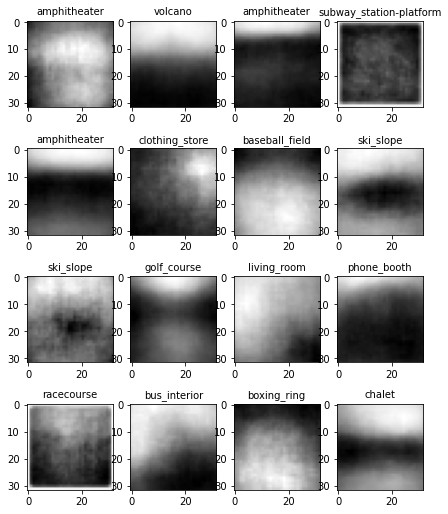

In [58]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [59]:
y_pred = mini_kmeans.predict(X_val)

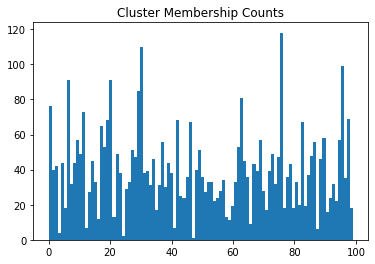

In [60]:
#plotting clusters in bin ranges
fig = plot_histogram(list(y_pred), bins=total_clusters, title="Cluster Membership Counts")

In [61]:
counts = Counter(list(y_pred))
counts.most_common()[0]

(76, 118)

In [62]:
y_pred_train_mini_kmeans = mini_kmeans.predict(X_train)
y_pred_test_mini_kmeans = mini_kmeans.predict(X_val)

In [63]:
mini_kmeans_train_accuracy = get_model_report(y_train, y_pred_train_mini_kmeans)
mini_kmeans_test_accuracy = get_model_report(y_val, y_pred_test_mini_kmeans)
models_summary = add_to_model_summary(models_summary, 'Mini KMeans', mini_kmeans_train_accuracy, mini_kmeans_test_accuracy)

Model Accuracy: 0.01
Model F1 Score: 0.01
Model Precision: 0.01
Model Recall: 0.01
Model Accuracy: 0.009
Model F1 Score: 0.009
Model Precision: 0.009
Model Recall: 0.009


Conclusion : This is the lowest accuracy we have got for any model

### Kmeans Clustering Algorithm

In [64]:
# Initialize the K-Means model
kmeans = KMeans(n_clusters = total_clusters, random_state=42)

# Fitting the model to training set
kmeans.fit(X_train)

# get the cluster labels
kmeans_labels = mini_kmeans.labels_

In [65]:
y_train_kmeans = y_train["category"].to_numpy()

In [66]:
reference_labels = get_reference_labels(kmeans_labels, y_train_kmeans, total_clusters)

# defining a dummy list of predicted labels
predicted_labels = np.random.rand(len(kmeans_labels))

for i in range(len(mini_kmeans.labels_)):
    predicted_labels[i] = reference_labels[kmeans_labels[i]]

In [67]:
print(accuracy_score(predicted_labels, y_train_kmeans))

0.04956666666666667


In [68]:
print(predicted_labels[:20].astype('int'))
print(y_train_kmeans[:20])

[85 47 37 53 87 30 83 88 37 25  8  8 57 41 87 23 73  8 88 84]
[92 79 86 35 20  7 30 88 19 80 27 92 39  3 87 50 79 77 78 84]


In [69]:
centroids = kmeans.cluster_centers_
centroids.shape

(100, 1024)

In [70]:
centroids = centroids.reshape(100, 32, 32)
centroids = centroids * 255

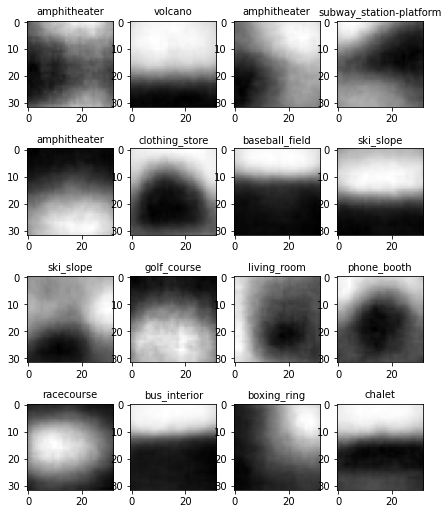

In [71]:
plt.figure(figsize = (10,9))
bottom = 0.35
for i in range(16):
    plt.subplots_adjust(bottom)
    plt.subplot(4, 4, i+1)
    plt.title(categories_dataset[reference_labels[i]], fontsize = 10)
    plt.imshow(centroids[i], cmap='gray')

In [72]:
y_pred = kmeans.predict(X_val)

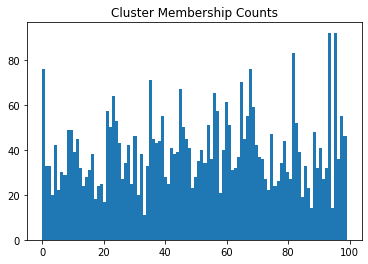

In [73]:
fig = plot_histogram(list(y_pred), bins=total_clusters, title="Cluster Membership Counts")

In [74]:
counts = Counter(list(y_pred))
counts.most_common()[0]

(94, 92)

In [75]:
y_pred_train_kmeans = kmeans.predict(X_train)
y_pred_test_kmeans = kmeans.predict(X_val)

In [76]:
kmeans_train_accuracy = get_model_report(y_train, y_pred_train_kmeans)
kmeans_test_accuracy = get_model_report(y_val, y_pred_test_kmeans)
models_summary = add_to_model_summary(models_summary, 'KMeans', kmeans_train_accuracy, kmeans_test_accuracy)

Model Accuracy: 0.009
Model F1 Score: 0.009
Model Precision: 0.009
Model Recall: 0.009
Model Accuracy: 0.01
Model F1 Score: 0.01
Model Precision: 0.01
Model Recall: 0.01


Conclusion : K means clustering has train accuracy 0.009 % and validation accuracy 0.1 %

## Decision Trees

In [77]:
model_DecisionTree = DecisionTreeClassifier()
model_DecisionTree.fit(X_train, y_train)

DecisionTreeClassifier()

In [78]:
cross_validation_accuracy_results = get_cross_validation(model_DecisionTree, X_train, y_train, 'accuracy', cv=10)

In [79]:
#printing K fold accuracy
print("Accuracy Scores across KFolds: ", cross_validation_accuracy_results)
print("Accuracy for Decision Tree: ", cross_validation_accuracy_results.mean())

Accuracy Scores across KFolds:  [0.025      0.021      0.026      0.02766667 0.018      0.02266667
 0.018      0.02333333 0.02233333 0.02466667]
Accuracy for Decision Tree:  0.022866666666666667


In [80]:
#passing below hyper paramters to test
params = {
            'max_depth': [2, 3, 5, 10, 20],
            'min_samples_leaf': [5, 10, 20, 50, 100],
            'max_leaf_nodes': [10, 30, 50, 100, 120],
            'criterion': ['gini', 'entropy'],
            'max_features': ['sqrt', 'log2']
        }

In [81]:
random_search = RandomizedSearchCV(estimator=model_DecisionTree, 
                                   param_distributions=params, 
                                   cv=5, 
                                   n_jobs=-1,
                                   n_iter=30,
                                   verbose=1, 
                                   scoring = 'accuracy',
                                   return_train_score = True)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=30,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 10, 20],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_leaf_nodes': [10, 30, 50, 100,
                                                           120],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             100]},
                   return_train_score=True, scoring='accuracy', verbose=1)

In [82]:
random_search_results_df = pd.DataFrame(random_search.cv_results_)
print("Combinations tried using Random Search CV: ", random_search_results_df.shape[0])

Combinations tried using Random Search CV:  30


In [83]:
# Gives a table of random Search CV 
random_search_results_df.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_leaf_nodes,param_max_features,param_max_depth,param_criterion,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.259963,0.003755,0.013508,0.000673,20,50,log2,10,gini,"{'min_samples_leaf': 20, 'max_leaf_nodes': 50,...",...,0.027633,0.001190,5,0.041500,0.040250,0.039792,0.040875,0.041875,0.040858,0.000769
1,2.894122,0.045003,0.013579,0.000837,10,30,sqrt,10,entropy,"{'min_samples_leaf': 10, 'max_leaf_nodes': 30,...",...,0.026767,0.002888,11,0.036750,0.036917,0.036042,0.036542,0.036250,0.036500,0.000320
2,0.409713,0.004492,0.011768,0.000786,5,30,sqrt,5,gini,"{'min_samples_leaf': 5, 'max_leaf_nodes': 30, ...",...,0.026867,0.001593,10,0.036625,0.035750,0.034667,0.035333,0.035125,0.035500,0.000662
3,0.230292,0.002412,0.011028,0.000063,50,50,log2,20,gini,"{'min_samples_leaf': 50, 'max_leaf_nodes': 50,...",...,0.028633,0.001896,1,0.042208,0.042208,0.044000,0.042792,0.042625,0.042767,0.000658
4,0.345824,0.005951,0.010414,0.000054,100,10,sqrt,5,gini,"{'min_samples_leaf': 100, 'max_leaf_nodes': 10...",...,0.024000,0.000745,19,0.027958,0.029375,0.028250,0.028958,0.027875,0.028483,0.000587
5,0.403588,0.011025,0.011324,0.000835,10,50,sqrt,5,gini,"{'min_samples_leaf': 10, 'max_leaf_nodes': 50,...",...,0.024900,0.001879,17,0.035500,0.036833,0.035958,0.037292,0.036542,0.036425,0.000633
6,0.381477,0.007769,0.012422,0.000212,5,10,sqrt,10,gini,"{'min_samples_leaf': 5, 'max_leaf_nodes': 10, ...",...,0.024500,0.000558,18,0.028625,0.027625,0.027583,0.027125,0.026542,0.027500,0.000685
7,0.928503,0.016280,0.011113,0.000378,20,30,log2,10,entropy,"{'min_samples_leaf': 20, 'max_leaf_nodes': 30,...",...,0.026900,0.001526,9,0.035000,0.035250,0.036125,0.036750,0.035083,0.035642,0.000684
8,0.962596,0.031314,0.012369,0.000424,5,30,log2,20,entropy,"{'min_samples_leaf': 5, 'max_leaf_nodes': 30, ...",...,0.025967,0.001443,14,0.035292,0.034500,0.035792,0.036500,0.035500,0.035517,0.000652
9,0.143768,0.010121,0.012187,0.002033,5,10,log2,3,gini,"{'min_samples_leaf': 5, 'max_leaf_nodes': 10, ...",...,0.020900,0.001083,26,0.025792,0.024042,0.025292,0.023375,0.024417,0.024583,0.000865


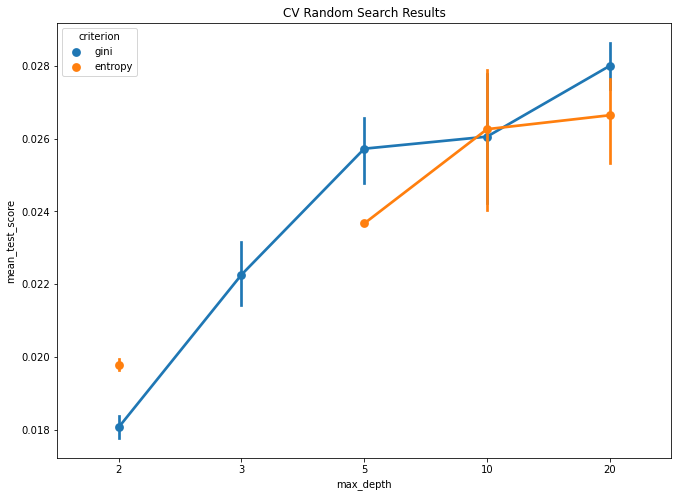

In [84]:
#plotting max_depth vs criterion
fig = plot_cv_results(random_search_results_df, 'max_depth', 'criterion')

In [85]:
print("Best parameters for the Decision Tree based on Random Search CV: \n", random_search.best_params_)

Best parameters for the Decision Tree based on Random Search CV: 
 {'min_samples_leaf': 50, 'max_leaf_nodes': 50, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini'}


In [86]:
print("Best Score for the Decision Tree based on Random Search CV:", random_search.best_score_)

Best Score for the Decision Tree based on Random Search CV: 0.028633333333333334


#### Trying with best parameters obtained from Random Search CV

In [87]:
# best paramters 
model_DecisionTree_best_params = DecisionTreeClassifier(min_samples_leaf=100, 
                                            max_leaf_nodes=100, 
                                            max_features='log2', 
                                            max_depth=20, 
                                            criterion='entropy')

In [88]:
# Training with 70% dataset
model_DecisionTree_best_params.fit(X_train_inventory, y_train_inventory)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='log2',
                       max_leaf_nodes=100, min_samples_leaf=100)

In [89]:
y_pred_train_decision_tree = model_DecisionTree_best_params.predict(X_train)
y_pred_test_decision_tree = model_DecisionTree_best_params.predict(X_val)

In [90]:
decision_tree_train_accuracy = get_model_report(y_train, y_pred_train_decision_tree)
decision_tree_test_accuracy = get_model_report(y_val, y_pred_test_decision_tree)
models_summary = add_to_model_summary(models_summary, 'Decision Tree', decision_tree_train_accuracy, decision_tree_test_accuracy)

Model Accuracy: 0.031
Model F1 Score: 0.018
Model Precision: 0.015
Model Recall: 0.031
Model Accuracy: 0.034
Model F1 Score: 0.02
Model Precision: 0.015
Model Recall: 0.034


Conclusion: With best parameters decision tree gives 3.1% accuracy in train and 3.4% in validation

### Linear Regression

In [91]:
model_linearRegression = LinearRegression()
model_linearRegression.fit(X_train, y_train)
model_linearRegression.score(X_train, y_train)

0.041159549173693355

---

##### Trying our combinations of parameters

In [92]:
model_linearRegression_1 = LinearRegression(fit_intercept=False,
                                          n_jobs=-1,
                                          positive=True)
model_linearRegression_1.fit(X_train, y_train)
model_linearRegression_1.score(X_train, y_train)

-0.11926099192607942

In [93]:
model_linearRegression_2 = LinearRegression(fit_intercept=False,
                                          n_jobs=-1,
                                          positive=False)
model_linearRegression_2.fit(X_train, y_train)
model_linearRegression_2.score(X_train, y_train)

-0.0868130394326172

In [94]:
model_linearRegression_3 = LinearRegression(fit_intercept=True,
                                          n_jobs=-1,
                                          positive=True)
model_linearRegression_3.fit(X_train, y_train)
model_linearRegression_3.score(X_train, y_train)

0.008190602474413167

---

In [97]:
# Going ahead with first combination of parameters used for model
model_linearRegression.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [95]:
y_train_pred_linearRegression = model_linearRegression.predict(X_train)

In [96]:
y_test_pred_linearRegression = model_linearRegression.predict(X_val)

##### Mean Squared and Root Mean Squared Error for train and test

In [98]:
LR_MSE_train = mean_squared_error(y_train, y_train_pred_linearRegression, squared = True)
LR_MSE_train

798.95380565102

In [99]:
LR_RMSE_train = mean_squared_error(y_train, y_train_pred_linearRegression, squared = False)
LR_RMSE_train

28.26577091909966

In [100]:
LR_MSE_test = mean_squared_error(y_val, y_test_pred_linearRegression, squared = True)
LR_MSE_test

858.2651132913851

In [101]:
LR_RMSE_test = mean_squared_error(y_val, y_test_pred_linearRegression, squared = False)
LR_RMSE_test

29.296162091499035

### Conclusion : The RMSE is 29.29 for test and 28.26 for train

### Logistic Regression

In [102]:
model_logisticRegression = LogisticRegression()
model_logisticRegression.fit(X_train, y_train)

LogisticRegression()

In [103]:
model_logisticRegression.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [104]:
y_train_pred_logisticRegression = model_logisticRegression.predict(X_train)

In [105]:
y_test_pred_logistic_Regression = model_logisticRegression.predict(X_val)

In [106]:
LG_MSE_test = mean_squared_error(y_val, y_test_pred_logistic_Regression, squared = True)
LG_MSE_test

1632.3105

In [107]:
LG_RMSE_test = mean_squared_error(y_val, y_test_pred_logistic_Regression, squared = False)
LG_RMSE_test

40.401862580826645

In [108]:
print(confusion_matrix(y_val, y_test_pred_logistic_Regression))
print("Logistic Regression accuracy ", accuracy_score(y_val, y_test_pred_logistic_Regression))
#logistic_regression_confusion

[[2 1 0 ... 2 3 0]
 [0 1 0 ... 0 0 0]
 [1 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 3 0 0]
 [1 0 0 ... 1 3 0]
 [0 1 1 ... 0 0 3]]
Logistic Regression accuracy  0.03725


---
##### Trying manual combination of hyperparameters

In [109]:
model_logisticRegression_1 = LogisticRegression(penalty='l2',
                                                C=0.1,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_1.fit(X_train, y_train)
y_train_pred_logisticRegression_1 = model_logisticRegression_1.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_1)

Model Accuracy: 0.17
Model F1 Score: 0.163
Model Precision: 0.175
Model Recall: 0.17


0.1697

In [110]:
model_logisticRegression_2 = LogisticRegression(penalty='l2',
                                                C=0.01,
                                                class_weight='balanced',
                                                solver='newton-cg',
                                                tol=1e-2
                                                )
model_logisticRegression_2.fit(X_train, y_train)
y_train_pred_logisticRegression_2 = model_logisticRegression_2.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_2)

Model Accuracy: 0.08
Model F1 Score: 0.066
Model Precision: 0.08
Model Recall: 0.08


0.08013333333333333

In [111]:
model_logisticRegression_3 = LogisticRegression(penalty='l2',
                                                C=0.0001,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_3.fit(X_train, y_train)
y_train_pred_logisticRegression_3 = model_logisticRegression_3.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_3)

Model Accuracy: 0.034
Model F1 Score: 0.013
Model Precision: 0.034
Model Recall: 0.034


0.03376666666666667

In [112]:
model_logisticRegression_4 = LogisticRegression(penalty='l2',
                                                C=0.1,
                                                class_weight='balanced',
                                                solver='lbfgs'
                                                )
model_logisticRegression_4.fit(X_train, y_train)
y_train_pred_logisticRegression_4 = model_logisticRegression_4.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_4)

Model Accuracy: 0.153
Model F1 Score: 0.146
Model Precision: 0.155
Model Recall: 0.153


0.15326666666666666

In [113]:
model_logisticRegression_5 = LogisticRegression(penalty='l2',
                                                C=1.0,
                                                class_weight='balanced',
                                                solver='newton-cg'
                                                )
model_logisticRegression_5.fit(X_train, y_train)
y_train_pred_logisticRegression_5 = model_logisticRegression_5.predict(X_train)
get_model_report(y_train, y_train_pred_logisticRegression_5)

Model Accuracy: 0.307
Model F1 Score: 0.304
Model Precision: 0.309
Model Recall: 0.307


0.3074

In [114]:
# adding model with best fit parameters to compare
y_test_pred_logisticRegression_5 = model_logisticRegression_5.predict(X_val)

logistic_regression_train_accuracy = get_model_report(y_train, y_train_pred_logisticRegression_5)
logistic_regression_test_accuracy = get_model_report(y_val, y_test_pred_logisticRegression_5)
models_summary = add_to_model_summary(models_summary, 
                                      'Logistic Regression', 
                                      logistic_regression_train_accuracy, 
                                      logistic_regression_test_accuracy)

Model Accuracy: 0.307
Model F1 Score: 0.304
Model Precision: 0.309
Model Recall: 0.307
Model Accuracy: 0.035
Model F1 Score: 0.033
Model Precision: 0.032
Model Recall: 0.035


---
##### Finding best parameters using Random Search CV

In [ ]:
params = {
            'solver': ['newton-cg', 'lbfgs', 'liblinear'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'C': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
         }

In [ ]:
random_search_LG = RandomizedSearchCV(estimator=model_logisticRegression, 
                                   param_distributions=params, 
                                   cv=5, 
                                   n_jobs=-1,
                                   n_iter=30,
                                   verbose=2, 
                                   scoring = 'accuracy',
                                   return_train_score = True)

random_search_LG.fit(X_train, y_train)

In [ ]:
random_search_LG_results_df = pd.DataFrame(random_search_LG.cv_results_)
print("Combinations tried using Random Search CV: ", random_search_LG_results_df.shape[0])

In [ ]:
random_search_LG_results_df.head(10)

In [ ]:
fig = plot_cv_results(random_search_LG_results_df, 'solver', 'C')

In [ ]:
print("Best parameters for the Logistic Regression based on Random Search CV: \n", random_search_LG.best_params_)

In [ ]:
print("Best Score for the Logistic Regression based on Random Search CV:", random_search_LG.best_score_)

---
##### Trying with best parameters obtained from Random Search CV

In [ ]:
model_logisticRegression_best_params = LogisticRegression(solver='',
                                                          C=,
                                                          penalty='')

In [ ]:
# Training with 70% dataset
model_DecisionTree_best_params.fit(X_train_inventory, y_train_inventory)

In [ ]:
y_pred_decision_tree = model_DecisionTree_best_params.predict(X_val)

---

# Sequential Neural Networks

In [115]:
def get_nn_model_performance(model_history, epoch_run):
    """ Display model performance for Neural Networks
    """
    train_acc = model_history.history['accuracy']
    train_loss = model_history.history['loss']
    val_acc = model_history.history['val_accuracy']
    val_loss = model_history.history['val_loss']

    epochs = [i for i in range(epoch_run)]
    fig , ax = plt.subplots(1,2)
    fig.set_size_inches(20, 10)

    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'ro-' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")

    plt.show()

In [116]:
# NN configurations 

def get_model_callbacks(monitor_metrix='val_loss', patience=10, min_delta=1e-2):
    """ EarlyStopping in case val_loss does not improve significantly
    """
    callbacks = [
                    keras.callbacks.EarlyStopping(     #
                        monitor=monitor_metrix,
                        min_delta=min_delta,
                        patience=patience,
                        verbose=1)
                ]
    
    return callbacks

# Initialize with a normal "Xavier" distribution
initializer = tf.keras.initializers.GlorotNormal()

def NN_model(layers):
    """ Returns the developed bidirectional lstm model
    """
    model = Sequential(layers)    
    return model


def fit_model(model, 
              X_train, y_train, 
              X_val=None, y_val=None, 
              batch_size=256, 
              epochs=50,
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'],
              patience=10):
    """ Compiling and Fitting the model on data
    
    Args:
        model: machine learning model to be trained on data
        X_train: Training dataset
        y_train: Training labels
        X_val: Validation dataset
        y_val: Validation labels
    Returns:
        model_history: history object with training & validation loss values and metrics values at successive epochs
    """
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=metrics) 
    
    callbacks = get_model_callbacks(monitor_metrix='val_loss', patience=patience, min_delta=1e-2)
    
    # fit the model
    model_history = model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=batch_size, 
                              epochs=epochs,
                              callbacks=callbacks)
    
    
    return model_history, model

---
##### Trying with Model option-1

In [119]:
dense_layers = []
dense_layers.append(Dense(512, kernel_initializer=initializer, input_dim=1024))
dense_layers.append(Dense(512, activation='relu'))
dense_layers.append(Dense(100, activation='softmax'))

NN_model(dense_layers).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 100)               51300     
                                                                 
Total params: 838,756
Trainable params: 838,756
Non-trainable params: 0
_________________________________________________________________


In [120]:
model_history_1, nn_model_1  = fit_model(NN_model(dense_layers), X_train, y_train, X_val, y_val)

Epoch 1/50
118/118 [==============================] - 1s 7ms/step - loss: 4.5875 - accuracy: 0.0182 - val_loss: 4.5069 - val_accuracy: 0.0235
Epoch 2/50
118/118 [==============================] - 1s 6ms/step - loss: 4.5066 - accuracy: 0.0267 - val_loss: 4.4733 - val_accuracy: 0.0305
Epoch 3/50
118/118 [==============================] - 1s 6ms/step - loss: 4.4643 - accuracy: 0.0318 - val_loss: 4.4513 - val_accuracy: 0.0318
Epoch 4/50
118/118 [==============================] - 1s 6ms/step - loss: 4.4244 - accuracy: 0.0363 - val_loss: 4.4236 - val_accuracy: 0.0377
Epoch 5/50
118/118 [==============================] - 1s 6ms/step - loss: 4.3901 - accuracy: 0.0409 - val_loss: 4.4136 - val_accuracy: 0.0405
Epoch 6/50
118/118 [==============================] - 1s 6ms/step - loss: 4.3623 - accuracy: 0.0435 - val_loss: 4.3858 - val_accuracy: 0.0417
Epoch 7/50
118/118 [==============================] - 1s 6ms/step - loss: 4.3259 - accuracy: 0.0488 - val_loss: 4.3831 - val_accuracy: 0.0472
Epoch 

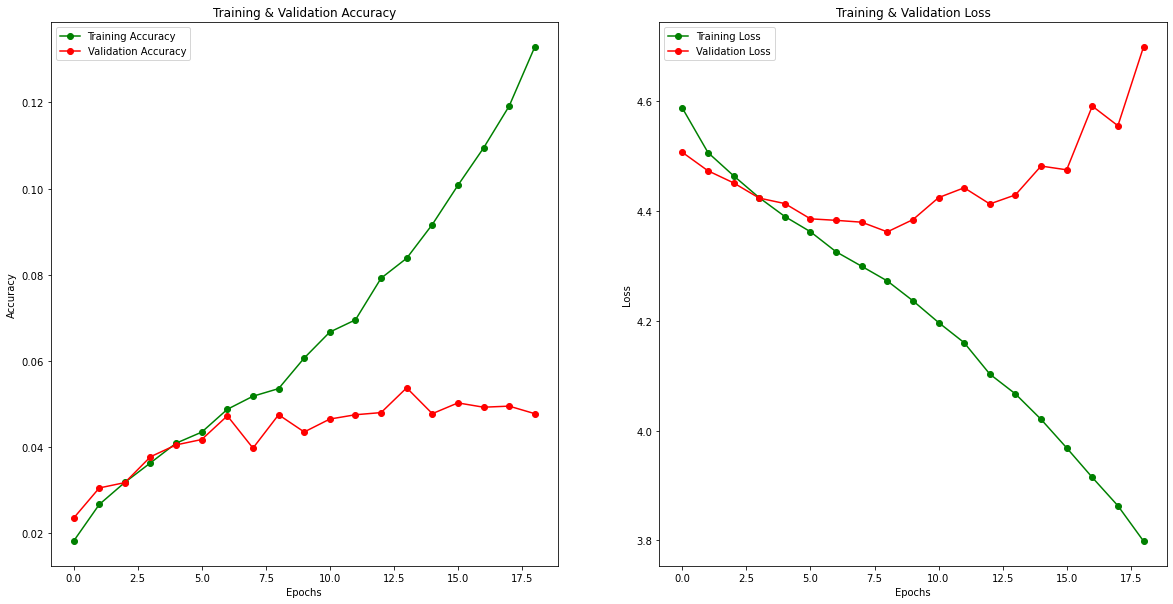

In [121]:
get_nn_model_performance(model_history_1, epoch_run=19)

In [160]:
nn_model_acuracy_1 = nn_model_1.evaluate(X_val_inventory, y_val_inventory)

188/188 [==============================] - 0s 1ms/step - loss: 4.7220 - accuracy: 0.0488


In [161]:
models_summary = add_to_model_summary(models_summary, 
                                      'Neural Network - Architecture-1 ', 
                                      0.13, 
                                      nn_model_acuracy_1[1]
                                      )

---
##### Trying with Model option-2

In [122]:
dense_layers = []
dense_layers.append(Dense(256, kernel_initializer=initializer, input_dim=1024))
dense_layers.append(Dense(128, activation='softmax'))
dense_layers.append(Dense(100, activation='softmax'))

NN_model(dense_layers).summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               262400    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 100)               12900     
                                                                 
Total params: 308,196
Trainable params: 308,196
Non-trainable params: 0
_________________________________________________________________


In [123]:
model_history_2, nn_model_2  = fit_model(NN_model(dense_layers), X_train, y_train, X_val, y_val)

Epoch 1/50
118/118 [==============================] - 1s 5ms/step - loss: 4.6088 - accuracy: 0.0085 - val_loss: 4.6053 - val_accuracy: 0.0100
Epoch 2/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6065 - accuracy: 0.0091 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 3/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6062 - accuracy: 0.0090 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 4/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6060 - accuracy: 0.0080 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 5/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6059 - accuracy: 0.0083 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 6/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6059 - accuracy: 0.0093 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 7/50
118/118 [==============================] - 0s 4ms/step - loss: 4.6058 - accuracy: 0.0091 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 

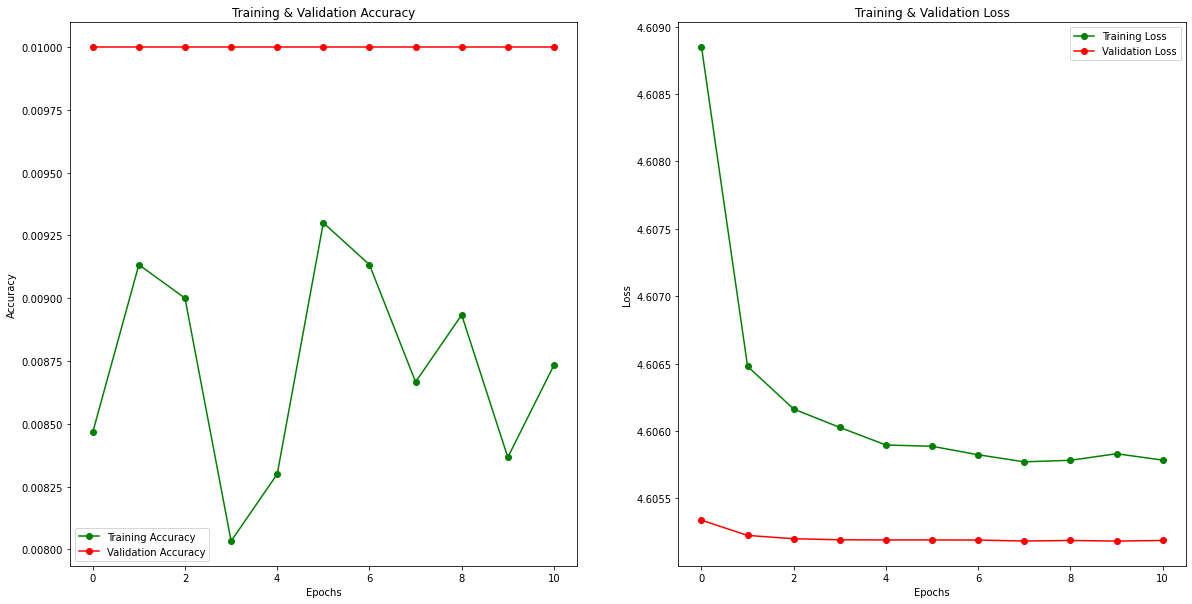

In [124]:
get_nn_model_performance(model_history_2, epoch_run=11)

---
##### Trying with Model option-3

In [125]:
dense_layers = []
dense_layers.append(Dense(1024, kernel_initializer=initializer, input_dim=1024))
dense_layers.append(Dense(512, activation='relu'))
dense_layers.append(Dense(256, activation='softmax'))
dense_layers.append(Dense(100, activation='softmax'))

NN_model(dense_layers).summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_10 (Dense)            (None, 512)               524800    
                                                                 
 dense_11 (Dense)            (None, 256)               131328    
                                                                 
 dense_12 (Dense)            (None, 100)               25700     
                                                                 
Total params: 1,731,428
Trainable params: 1,731,428
Non-trainable params: 0
_________________________________________________________________


In [126]:
model_history_3, nn_model_3 = fit_model(NN_model(dense_layers), 
                                        X_train, y_train, X_val, y_val,
                                        batch_size=300, 
                                        epochs=200,
                                        optimizer = Adam(lr=0.001),
                                        metrics=['accuracy'])

Epoch 1/200
100/100 [==============================] - 2s 12ms/step - loss: 4.6078 - accuracy: 0.0093 - val_loss: 4.6074 - val_accuracy: 0.0100
Epoch 2/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6072 - accuracy: 0.0090 - val_loss: 4.6061 - val_accuracy: 0.0100
Epoch 3/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6063 - accuracy: 0.0092 - val_loss: 4.6056 - val_accuracy: 0.0100
Epoch 4/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6060 - accuracy: 0.0090 - val_loss: 4.6054 - val_accuracy: 0.0100
Epoch 5/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6058 - accuracy: 0.0100 - val_loss: 4.6053 - val_accuracy: 0.0100
Epoch 6/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6057 - accuracy: 0.0089 - val_loss: 4.6052 - val_accuracy: 0.0100
Epoch 7/200
100/100 [==============================] - 1s 11ms/step - loss: 4.6057 - accuracy: 0.0088 - val_loss: 4.6052 - val_accuracy:

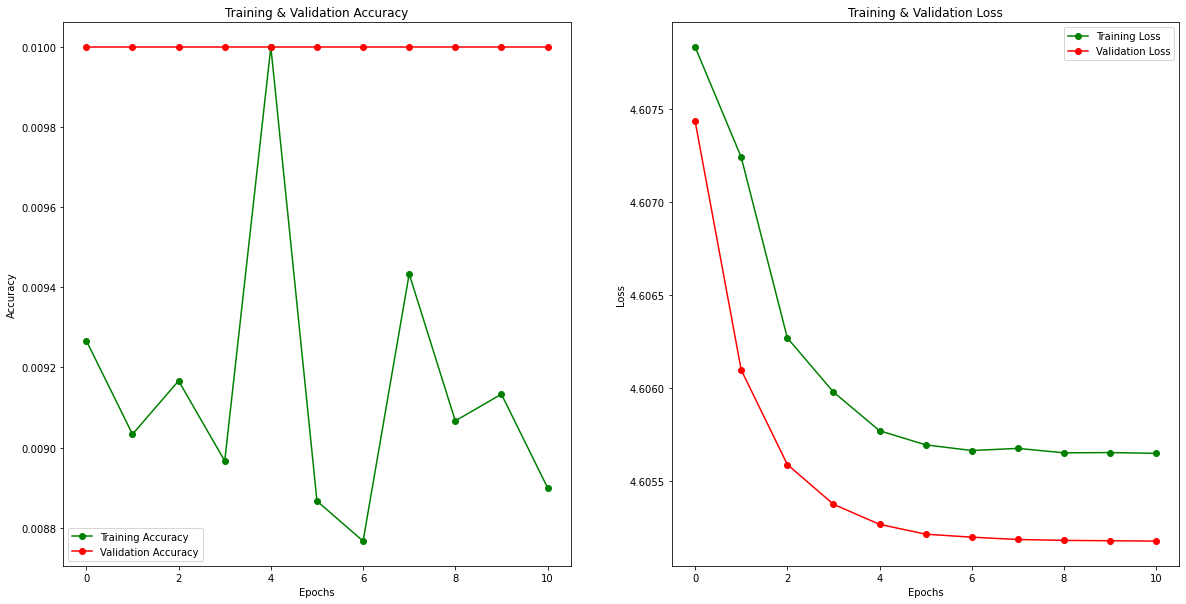

In [127]:
get_nn_model_performance(model_history_3, epoch_run=11)

---
##### Trying with Model option-1 with 90% training data

In [132]:
dense_layers = []
dense_layers.append(Flatten(input_shape=[32, 32]))
dense_layers.append(Dense(512, activation='relu'))
dense_layers.append(Dense(100, activation='softmax'))

NN_model(dense_layers).summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_19 (Dense)            (None, 512)               524800    
                                                                 
 dense_20 (Dense)            (None, 100)               51300     
                                                                 
Total params: 576,100
Trainable params: 576,100
Non-trainable params: 0
_________________________________________________________________


In [133]:
model_history_4, nn_model_4  = fit_model(NN_model(dense_layers), X_train_nn, y_train_nn, X_val_nn, y_val_nn, epochs=200)

Epoch 1/200
352/352 [==============================] - 2s 5ms/step - loss: 4.5267 - accuracy: 0.0235 - val_loss: 4.4725 - val_accuracy: 0.0285
Epoch 2/200
352/352 [==============================] - 2s 4ms/step - loss: 4.4547 - accuracy: 0.0320 - val_loss: 4.4369 - val_accuracy: 0.0386
Epoch 3/200
352/352 [==============================] - 2s 4ms/step - loss: 4.4288 - accuracy: 0.0364 - val_loss: 4.4173 - val_accuracy: 0.0386
Epoch 4/200
352/352 [==============================] - 2s 4ms/step - loss: 4.3973 - accuracy: 0.0406 - val_loss: 4.3873 - val_accuracy: 0.0421
Epoch 5/200
352/352 [==============================] - 2s 4ms/step - loss: 4.3770 - accuracy: 0.0431 - val_loss: 4.3802 - val_accuracy: 0.0443
Epoch 6/200
352/352 [==============================] - 2s 4ms/step - loss: 4.3615 - accuracy: 0.0452 - val_loss: 4.3600 - val_accuracy: 0.0473
Epoch 7/200
352/352 [==============================] - 2s 4ms/step - loss: 4.3529 - accuracy: 0.0457 - val_loss: 4.3614 - val_accuracy: 0.0460

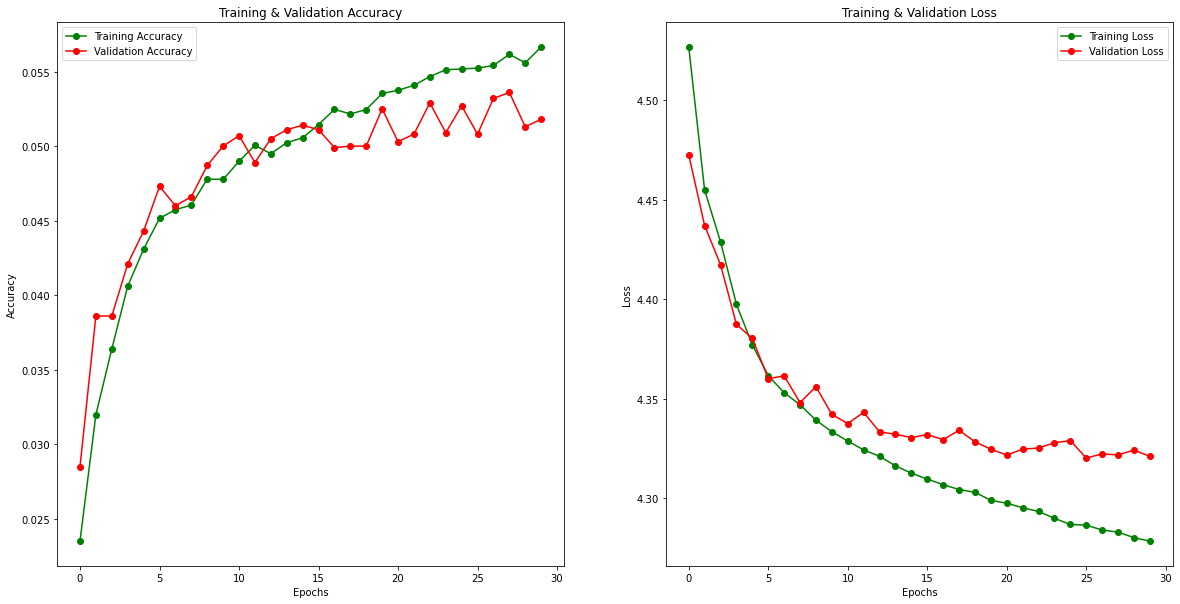

In [134]:
get_nn_model_performance(model_history_4, epoch_run=30)

In [135]:
nn_model_acuracy_4 = nn_model_4.evaluate(X_test_nn, y_test_nn)

313/313 [==============================] - 0s 1ms/step - loss: 4.3189 - accuracy: 0.0511


In [138]:
models_summary = add_to_model_summary(models_summary, 
                                      'Neural Network - 90% Data ', 
                                      0.056, 
                                      nn_model_acuracy_4[1]
                                      )

---
##### Trying with Model option-1 with 90% training data and new combination of hyperparameters

In [139]:
model_history_5, nn_model_5 = fit_model(NN_model(dense_layers), 
                                        X_train_nn, y_train_nn, 
                                        X_val_nn, y_val_nn,
                                        batch_size=400, 
                                        epochs=500,
                                        optimizer = Adam(lr=1),)

Epoch 1/500
225/225 [==============================] - 2s 6ms/step - loss: 15.3125 - accuracy: 0.0104 - val_loss: 4.6912 - val_accuracy: 0.0100
Epoch 2/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6960 - accuracy: 0.0104 - val_loss: 4.6937 - val_accuracy: 0.0100
Epoch 3/500
225/225 [==============================] - 1s 6ms/step - loss: 4.7043 - accuracy: 0.0100 - val_loss: 4.6970 - val_accuracy: 0.0100
Epoch 4/500
225/225 [==============================] - 1s 6ms/step - loss: 4.7006 - accuracy: 0.0101 - val_loss: 4.7130 - val_accuracy: 0.0100
Epoch 5/500
225/225 [==============================] - 1s 6ms/step - loss: 4.7066 - accuracy: 0.0097 - val_loss: 4.7304 - val_accuracy: 0.0100
Epoch 6/500
225/225 [==============================] - 1s 6ms/step - loss: 4.7071 - accuracy: 0.0099 - val_loss: 4.7034 - val_accuracy: 0.0100
Epoch 7/500
225/225 [==============================] - 1s 6ms/step - loss: 4.7010 - accuracy: 0.0099 - val_loss: 4.7116 - val_accuracy: 0.010

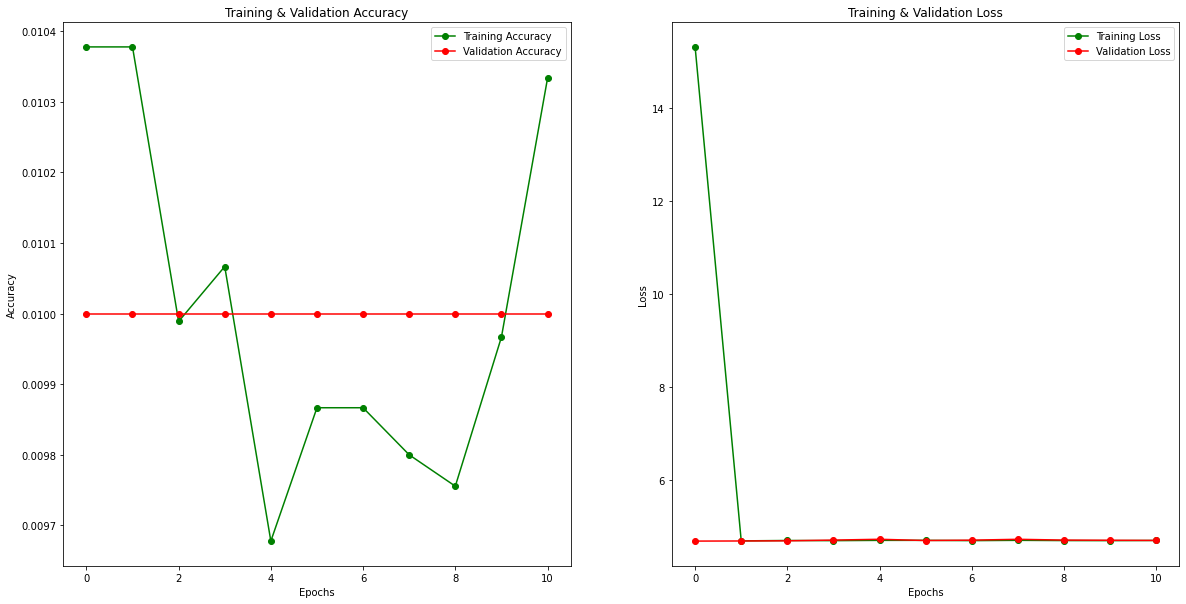

313/313 [==============================] - 1s 1ms/step - loss: 4.7052 - accuracy: 0.0100


In [140]:
get_nn_model_performance(model_history_5, epoch_run=11)
nn_model_acuracy_5 = nn_model_5.evaluate(X_test_nn, y_test_nn)

In [141]:
model_history_6, nn_model_6 = fit_model(NN_model(dense_layers), 
                                        X_train_nn, y_train_nn, 
                                        X_val_nn, y_val_nn,
                                        batch_size=400, 
                                        epochs=500,
                                        optimizer = Adam(lr=0.001))

Epoch 1/500
225/225 [==============================] - 2s 6ms/step - loss: 4.6822 - accuracy: 0.0100 - val_loss: 4.6623 - val_accuracy: 0.0100
Epoch 2/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6487 - accuracy: 0.0100 - val_loss: 4.6371 - val_accuracy: 0.0100
Epoch 3/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6293 - accuracy: 0.0100 - val_loss: 4.6226 - val_accuracy: 0.0100
Epoch 4/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6184 - accuracy: 0.0100 - val_loss: 4.6145 - val_accuracy: 0.0100
Epoch 5/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6123 - accuracy: 0.0100 - val_loss: 4.6101 - val_accuracy: 0.0100
Epoch 6/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6090 - accuracy: 0.0100 - val_loss: 4.6077 - val_accuracy: 0.0100
Epoch 7/500
225/225 [==============================] - 1s 6ms/step - loss: 4.6072 - accuracy: 0.0100 - val_loss: 4.6064 - val_accuracy: 0.0100

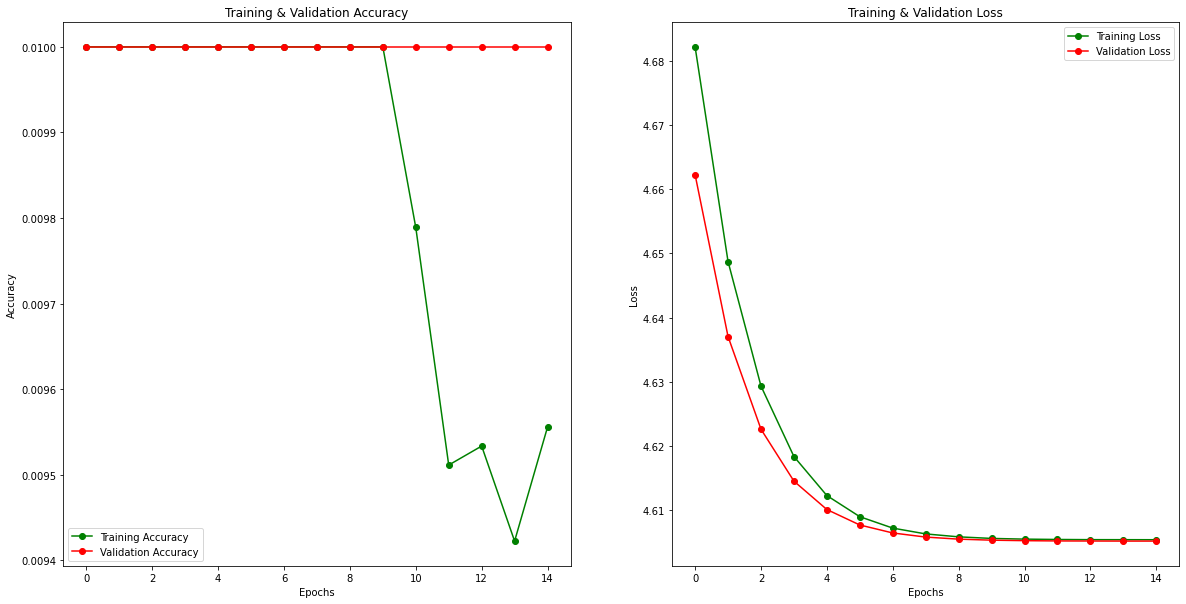

313/313 [==============================] - 1s 2ms/step - loss: 4.6052 - accuracy: 0.0100


In [143]:
get_nn_model_performance(model_history_6, epoch_run=15)
nn_model_acuracy_6 = nn_model_6.evaluate(X_test_nn, y_test_nn)

---

## Convolutional Neural Network

---
##### Convolutional Network Architecture - 1

In [144]:
# defining layers for CNN Architecture 1
layers = []
layers.append(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(32,32, 1), padding='same', data_format='channels_last'))
layers.append(Flatten())
layers.append(Dense(100, activation='softmax'))

NN_model(layers).summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_21 (Dense)            (None, 100)               6553700   
                                                                 
Total params: 6,554,340
Trainable params: 6,554,340
Non-trainable params: 0
_________________________________________________________________


In [145]:
cnn_model_history_1, cnn_model_1  = fit_model(NN_model(layers), X_train_nn, y_train_nn, X_val_nn, y_val_nn, epochs=50, patience=10)

Epoch 1/50
352/352 [==============================] - 49s 138ms/step - loss: 4.4278 - accuracy: 0.0451 - val_loss: 4.2293 - val_accuracy: 0.0610
Epoch 2/50
352/352 [==============================] - 49s 139ms/step - loss: 4.0966 - accuracy: 0.0858 - val_loss: 4.1927 - val_accuracy: 0.0691
Epoch 3/50
352/352 [==============================] - 49s 138ms/step - loss: 3.9794 - accuracy: 0.1037 - val_loss: 4.1658 - val_accuracy: 0.0763
Epoch 4/50
352/352 [==============================] - 48s 137ms/step - loss: 3.8782 - accuracy: 0.1221 - val_loss: 4.1680 - val_accuracy: 0.0784
Epoch 5/50
352/352 [==============================] - 48s 138ms/step - loss: 3.7537 - accuracy: 0.1446 - val_loss: 4.1308 - val_accuracy: 0.0887
Epoch 6/50
352/352 [==============================] - 49s 138ms/step - loss: 3.5877 - accuracy: 0.1741 - val_loss: 4.1289 - val_accuracy: 0.0913
Epoch 7/50
352/352 [==============================] - 48s 137ms/step - loss: 3.4691 - accuracy: 0.1977 - val_loss: 4.1573 - val_ac

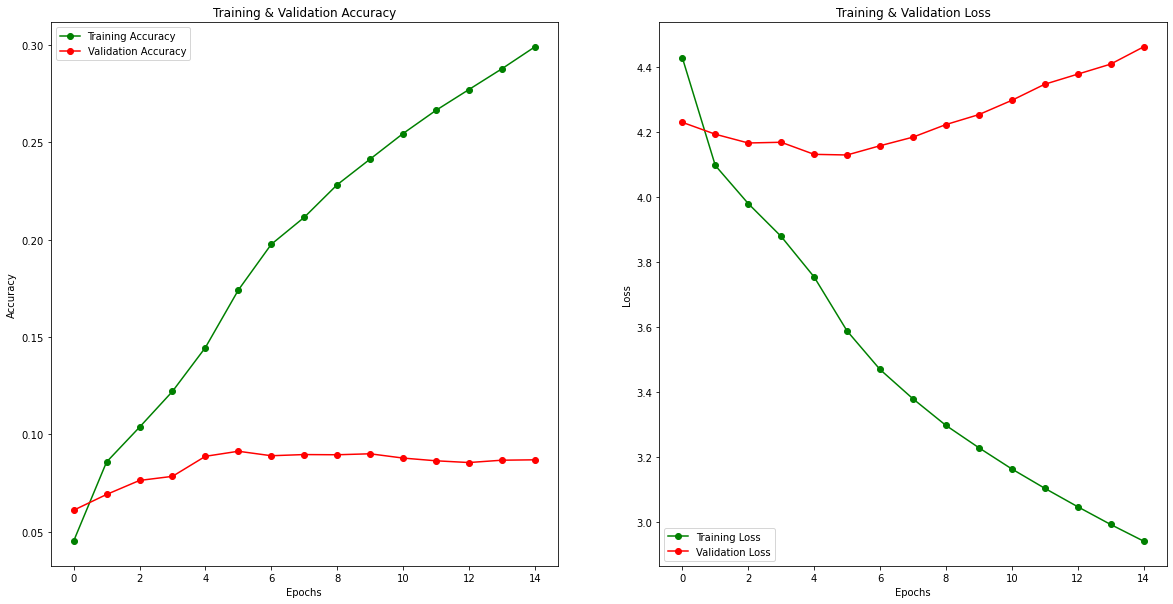

In [146]:
get_nn_model_performance(cnn_model_history_1, epoch_run=15)

In [148]:
cnn_model_acuracy_1 = cnn_model_1.evaluate(X_test_nn, y_test_nn)

313/313 [==============================] - 2s 8ms/step - loss: 4.4505 - accuracy: 0.0860


---
##### Convolutional Network Architecture - 2

In [149]:
# defining layers for CNN Architecture 2
layers = []
layers.append(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(32,32, 1), padding='same', data_format='channels_last'))
layers.append(MaxPooling2D(2, 2, data_format='channels_last'))
layers.append(Conv2D(32, kernel_size=(3,3), activation='relu', data_format='channels_last'))
layers.append(MaxPooling2D(2, 2, data_format='channels_last'))
layers.append(Flatten())
layers.append(Dense(100, activation='softmax'))

NN_model(layers).summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_22 (Dense)            (None, 100)             

In [150]:
cnn_model_history_2, cnn_model_2  = fit_model(NN_model(layers), X_train_nn, y_train_nn, X_val_nn, y_val_nn, epochs=50, patience=10)

Epoch 1/50
352/352 [==============================] - 40s 114ms/step - loss: 4.3996 - accuracy: 0.0416 - val_loss: 4.2317 - val_accuracy: 0.0629
Epoch 2/50
352/352 [==============================] - 40s 114ms/step - loss: 4.1345 - accuracy: 0.0789 - val_loss: 4.0995 - val_accuracy: 0.0839
Epoch 3/50
352/352 [==============================] - 40s 114ms/step - loss: 4.0473 - accuracy: 0.0923 - val_loss: 4.0672 - val_accuracy: 0.0846
Epoch 4/50
352/352 [==============================] - 40s 114ms/step - loss: 4.0019 - accuracy: 0.0997 - val_loss: 4.0352 - val_accuracy: 0.0959
Epoch 5/50
352/352 [==============================] - 41s 115ms/step - loss: 3.9774 - accuracy: 0.1044 - val_loss: 4.0218 - val_accuracy: 0.0978
Epoch 6/50
352/352 [==============================] - 40s 114ms/step - loss: 3.9574 - accuracy: 0.1070 - val_loss: 4.0068 - val_accuracy: 0.0980
Epoch 7/50
352/352 [==============================] - 40s 114ms/step - loss: 3.9441 - accuracy: 0.1097 - val_loss: 4.0248 - val_ac

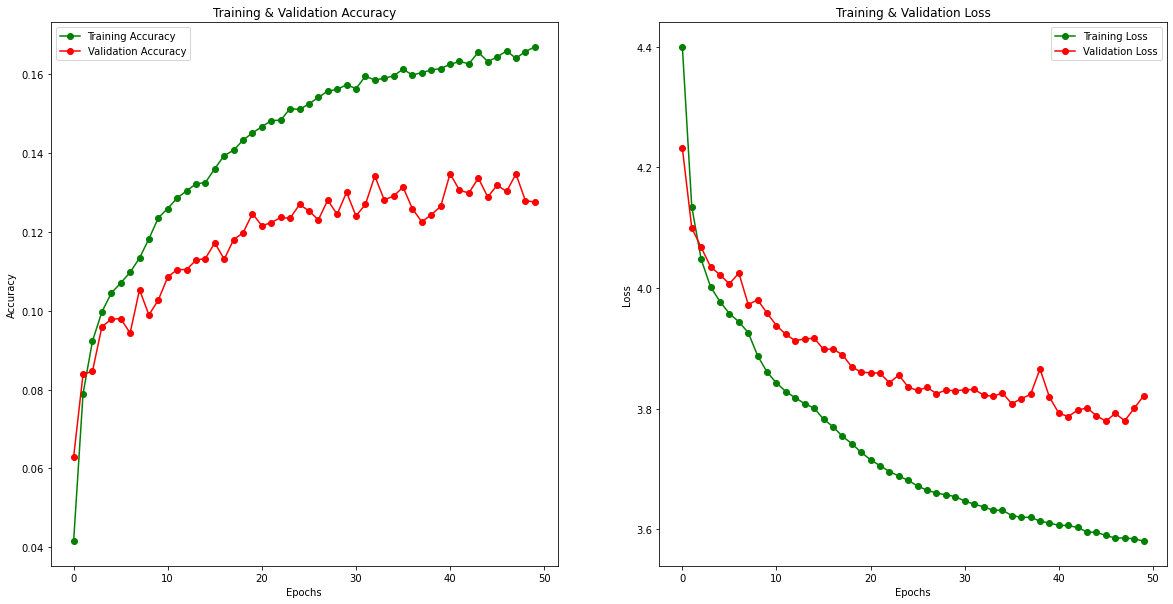

In [152]:
get_nn_model_performance(cnn_model_history_2, epoch_run=50)

In [153]:
cnn_model_acuracy_2 = cnn_model_2.evaluate(X_test_nn, y_test_nn)

313/313 [==============================] - 1s 5ms/step - loss: 3.7843 - accuracy: 0.1349


In [156]:
models_summary = add_to_model_summary(models_summary, 
                                      'CNN - Architecture-2 - 90% Data ', 
                                      0.17, 
                                      cnn_model_acuracy_2[1]
                                      )

---
##### Convolutional Network Architecture - 2 with changed Hyperparameters

In [154]:
# changing learning rate for the model to 0.01
cnn_model_history_3, cnn_model_3  = fit_model(NN_model(layers), 
                                              X_train_nn, y_train_nn, 
                                              X_val_nn, y_val_nn, 
                                              optimizer = Adam(lr=0.01),
                                              epochs=50, 
                                              patience=10)

Epoch 1/50
352/352 [==============================] - 41s 115ms/step - loss: 4.1796 - accuracy: 0.0805 - val_loss: 3.9726 - val_accuracy: 0.1017
Epoch 2/50
352/352 [==============================] - 40s 113ms/step - loss: 3.8581 - accuracy: 0.1191 - val_loss: 3.9192 - val_accuracy: 0.1087
Epoch 3/50
352/352 [==============================] - 40s 113ms/step - loss: 3.7940 - accuracy: 0.1291 - val_loss: 3.8764 - val_accuracy: 0.1192
Epoch 4/50
352/352 [==============================] - 40s 112ms/step - loss: 3.7654 - accuracy: 0.1327 - val_loss: 3.8595 - val_accuracy: 0.1171
Epoch 5/50
352/352 [==============================] - 40s 113ms/step - loss: 3.7393 - accuracy: 0.1363 - val_loss: 3.9637 - val_accuracy: 0.1062
Epoch 6/50
352/352 [==============================] - 39s 112ms/step - loss: 3.7274 - accuracy: 0.1380 - val_loss: 3.9195 - val_accuracy: 0.1108
Epoch 7/50
352/352 [==============================] - 40s 113ms/step - loss: 3.7180 - accuracy: 0.1391 - val_loss: 3.8700 - val_ac

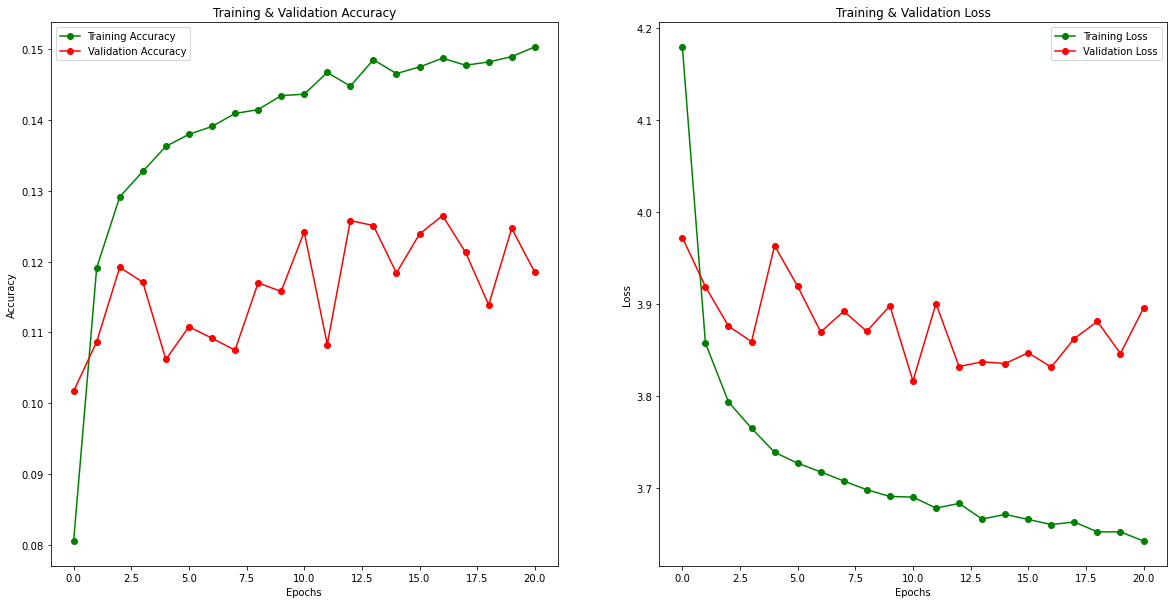

In [155]:
get_nn_model_performance(cnn_model_history_3, epoch_run=21)

In [157]:
cnn_model_acuracy_3 = cnn_model_3.evaluate(X_test_nn, y_test_nn)
models_summary = add_to_model_summary(models_summary, 
                                      'CNN - Architecture-2 - HP - 90% Data ', 
                                      0.15, 
                                      cnn_model_acuracy_3[1]
                                      )

313/313 [==============================] - 1s 4ms/step - loss: 3.8736 - accuracy: 0.1210


### Conclusion : We have got accuracy of 1.2% 

---

## Model Comparisons

In [162]:
models_summary.head(20)

,Model Name,Train Accuracy,Test Accuracy
0,SGD Classifier,0.065967,0.019750
1,Multinomial NB,0.038467,0.034750
2,Gaussian NB,0.051000,0.044250
3,Complement NB,0.026600,0.025750
4,Mini KMeans,0.010233,0.009000
5,KMeans,0.009100,0.010500
6,Decision Tree,0.030667,0.033750
7,Logistic Regression,0.307400,0.034750
8,Neural Network - 90% Data,0.056000,0.051100
9,CNN - Architecture-2 - 90% Data,0.170000,0.134900


## Above is Final Table comparisons for all the models we tried 